<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg" align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">Trabajo Fin de Máster</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Autor: César Fernández Domínguez</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Análisis descriptivo de datos de tráfico para la ciudad de Barcelona

Este análisis se ha organizado en los siguientes apartados:

 <ol start="1">
  <li>Carga del conjunto de datos
  <br>1.1 Carga de datos tráfico en la ciudad de Barcelona
  <br>1.2 Carga de metadatos de identificación de tramos de tráfico en la ciudad de Barcelona
  <li>Análisis de los datos
  <br>2.1 Análisis estadístico básico
  <br>2.2 Análisis exploratorio de los datos
  <li>Selección de tramos
</ol>
   
En primer lugar, cargamos todas las librerías que vamos a necesitar:

In [1]:
import sys
import numpy as np
import pandas as pd
import datetime as dt
import folium
import random
import seaborn;
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
from matplotlib.pylab import rcParams
from statistics import mean
%matplotlib inline
pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 12, 8
rcParams['font.size'] = 10

# 1. Carga del conjunto de datos

En este apartado vamos a realizar la carga y análisis de datos relativos al estado del tránsito en distintos tramos de la ciudad de Barcelona. Esta información es proporcionada por el ayuntamiento de Barcelona en su página de Open Data en la url:
https://opendata-ajuntament.barcelona.cat/data/es/dataset/trams. Desde este enlace es posible descargar datos de estado de tránsito desde octuble de 2017, en fichero históricos agrupados mensualmente y clasificados por año y mes. Según la propia descripción de los datos, dada en esta página, los espacios temporales irregulares responen a invariabilidad del estado del tránsito, por lo tanto, podremos interpolar según el último valor registrado. Los ficheros se presentan en formato csv.

Además de los ficheros conteniendo la información de tránsito mensual, es proporcionado también un fichero de metadatos con información de cada uno de los tramos de la vía pública identificados por un código, nombre de vía (entre otros tramos) y coordenadas de la ciudad de Barcelona. El acceso a estos metadatos en proporcionado desde el enlace:https://opendata-ajuntament.barcelona.cat/data/es/dataset/transit-relacio-trams.

Licencia: [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/)


## 1.1 Carga de datos tráfico en la ciudad de Barcelona

Procedemos ahora a realizar la carga de los datos descargados de tránsito en los distintos tramos definidos en la ciudad de Barcelona. Se dispone de datos desde octubre de 2017 hasta abril de 2020.

El siguiente código nos permite cargar estos datos entre dos meses definidos a través de las variables 'dataStartTime' y 'dataEndTime'. Como puede verse en el código, los cuatro atributos leidos del fichero se han definido de tipo 'object', pues, como veremos más adelante, estos datos realmente deben ser tratados como variables cualitativas.

In [2]:
dataStartTime = "2017-10"
dataEndTime = "2020-04"

# Header definition
columns=['idTram', 'data', 'estatActual', 'estatPrevist']
dtype={'idTram':np.integer, 'data':object, 'estatActual':object, 'estatPrevist':object}
monthLUT={1:'Gener',2:'Febrer',3:'Marc',4:'Abril',5:'Maig',6:'Juny',7:'Juliol',8:'Agost',9:'Setembre',10:'Octubre',11:'Novembre',12:'Desembre'}

# Read data to dataframe
data_trafico = pd.DataFrame(columns=columns)
for time in pd.date_range(dataStartTime+"-01T00:00:00.000", dataEndTime+"-01T00:00:00.000", freq='MS'):
    filename = time.strftime("../data/trafico/%Y_%m_{}_TRAMS_TRAMS.zip".format(monthLUT[time.month]))
    sys.stdout.write(200*' '+'\r')
    sys.stdout.write('Reading file: \x1b[31m{}\x1b[0m \r'.format(filename))
    sys.stdout.flush()
    data_trafico = data_trafico.append(
        #pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "ISO-8859-1", dtype=dtype)
        pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "UTF-8", dtype=dtype)
        , ignore_index = True)

In [3]:
data_trafico.shape

(75821160, 4)

Comprobamos que no se ha cargado ninguna instancia repetida. Si así fuera, tendríamos que eliminar aquellas que se repitan.

In [4]:
# Check whether duplicated rows and remove them, if so
duplicateRowsDF = data_trafico[data_trafico.duplicated()]
if len(duplicateRowsDF):
    data_trafico.drop_duplicates(inplace=True)  
    
print("Número de instancias duplicadas eliminadas: %d" % (len(duplicateRowsDF)))
data_trafico.shape

Número de instancias duplicadas eliminadas: 7995


(75813165, 4)

Mostramos las primeras instancias de nuestro dataframe:

In [5]:
# Show first values in dataframe
data_trafico.head()

,idTram,data,estatActual,estatPrevist
0,1,20171001002055,1,1
1,2,20171001002055,1,1
2,3,20171001002055,0,0
3,4,20171001002055,2,2
4,5,20171001002055,1,1


Vemos como los datos están organizados en 8 columnas, que son:

- 'idTram', identificador del tramo según la relación dada en el fichero de metadatos cargado arriba.
- 'data', fecha del registro.
- 'estatActual', se corresponde con el estado de tránsito en la fecha indicada. Puede tomar los valores: 0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat.
- 'estatPrevist', es el estado previsto, de tránsito, dentro de 15 minutos después de la fecha indicada. Puede tomar los valores: 0 = sense dades / 1 = molt fluid / 2 = fluid / 3 = dens / 4 = molt dens / 5 = congestió / 6 = tallat.


## 1.2. Carga de metadatos de identificación de tramos de tráfico en la ciudad de Barcelona

Actualmente hay definidos cerca de 500 tramos de vía pública dentro del callejero de la ciudad de Barcelona, para los cuales se realiza un seguimiento del tránsito de vehículos. Para identificar estos tramos, el ayuntamiento de Barcelona proporciona un fichero en formato csv con un listado de estos tramos. Cada tramo es identificado por un número y, para cada tramo se incluye una descripción del nombre de la calle/vía por el cual transcurre y información geográfica con las coordenadas de los puntos que describen este.

En nuestro caso ya disponemos el fichero de metadatos descargado localmente, por lo que procedemos a cargarlo como un dataframe.

In [6]:
# Header definition
columns=['Tramo', 'Descripcion', 'Coordenadas']
dtype={'Tramo':np.integer, 'Descripcion':object, 'Coordenadas':object}

filename = "../data/trafico/meta/transit_relacio_trams.csv"
data_tramos = pd.read_csv(filename, header=0, names=columns, sep=',', encoding = "UTF-8", dtype=dtype)

Comprobamos que la estructura de nuestro dataframe está definida por 491 filas/tramos y 3 parámetros o atributos.

In [7]:
data_tramos.shape

(491, 3)

A continuación, mostramos las primeras cinco instancias de la tabla cargada.

In [8]:
data_tramos.head()

,Tramo,Descripcion,Coordenadas
0,1,Diagonal (Ronda de Dalt a Doctor Marañón),"2.11203535639414,41.3841912394771,2.1015028628..."
1,2,Diagonal (Doctor Marañón a Ronda de Dalt),"2.111944376806616,41.38446666680338,2.10159408..."
2,3,Diagonal (Doctor Marañón a Pl. Pius XII),"2.112093343037027,41.38422850920645,2.12264979..."
3,4,Diagonal (Pl. Pius XII a Doctor Marañón),"2.122592049318304,41.38719094189204,2.11196902..."
4,5,Diagonal (Pl. Pius XII a Pl. Maria Cristina),"2.122657659295115,41.38694195794678,2.12755961..."


Esta información podemos representarla sobre un mapa de Barcelona, de forma que resulta más fácil identificar la ubicación exacta de cada tramo. Si ha intentado asignar un color distinto a cada tramo para permitir una mejor diferenciación entre tramos:

In [9]:
# Create a Map instance
m = folium.Map(location=[41.37, 2.17], 
               width=1250, height=1300,
               zoom_start=13, 
               min_zoom=13, max_zoom=13, 
               control_scale=False, zoom_control=False)

# In order to generate random colors
r = lambda: random.randint(0,255)

# Represents all the trafic routes on the map
for index, row in data_tramos.iterrows():
    coordenadas=np.array(row['Coordenadas'].split(','))
    coordenadas = coordenadas.astype(np.float)
    coordenadas=np.reshape(coordenadas, (-1, 2))
    coordenadas[:,[0, 1]] = coordenadas[:,[1, 0]]
    
    if len(coordenadas) > 1:
        # Mark first and last points
        folium.CircleMarker(coordenadas[0],
                            radius=2, color="#3db7e4").add_to(m)
        folium.CircleMarker(coordenadas[len(coordenadas) - 1],
                            radius=2, color="#3db7e4").add_to(m)
        
        # Paint polyline for the trafic route
        text='Numero de tramo: <b>{:d}</b><br>{}'.format(int(row['Tramo']), row['Descripcion'])
        folium.PolyLine(coordenadas, tooltip=text,
                        color='#%02X%02X%02X' % (r(),r(),r()),
                        fill_opacity=0.3
                       ).add_to(m)
m

# 2. Análisis de los datos

## 2.1 Análisis estadístico básico

Mostramos la distribución de los datos cargados:

In [10]:
data_trafico.describe(include='O')

,idTram,data,estatActual,estatPrevist
count,75813165,75813165,75813165,75813165
unique,534,143320,7,7
top,267,20180206050552,0,0
freq,143320,534,38129219,40808852


Como podemos ver en esta tabla, únicamente tenemos datos para 527 tramos, del 591 que vimos arriba que estaban definidos. Para los atríbutos de 'estatActual' y 'estatPrevist' vemos que ambos toman los 7 valores posibles, sin embargo, la gran mayoría de estos valores es el valor 0, que significa que no hay dato. 

Para los siguientes representaciones gráficas necesitamos tratar los atributos 'estatActual' y 'estatPrevist' como numéricos.

In [11]:
data_trafico['estatActual'] = pd.to_numeric(data_trafico['estatActual'])
data_trafico['estatPrevist'] = pd.to_numeric(data_trafico['estatPrevist'])

La siguiente fígura muestra la frecuencia de aparición de cada valor para los atríbutos 'estatActual' y 'estatPrevist', en todos los tramos.

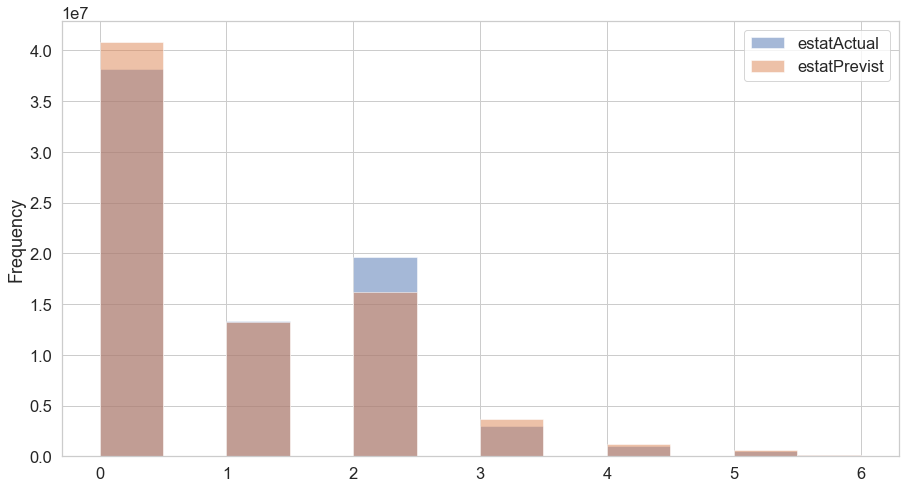

In [12]:
seaborn.set(font_scale=1.5, style="whitegrid")
data_trafico.loc[(data_trafico["idTram"] != '0'), ['estatActual','estatPrevist']].plot.hist(bins=12, alpha=0.5, figsize=(15,8))
plt.show()

Si nos enfocamos en un solo tramo, podemos obtener un histograma como el siguiente:

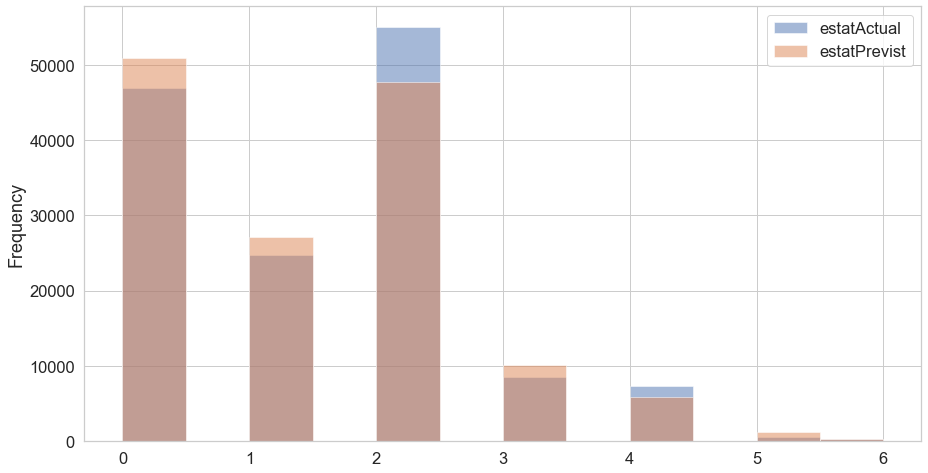

In [13]:
seaborn.set(font_scale=1.5, style="whitegrid")
data_trafico.loc[(data_trafico["idTram"] == 1), ['estatActual','estatPrevist']].plot.hist(bins=12, alpha=0.5, figsize=(15,8))
plt.show()

Vemos que, en la mayoría de las veces, el tránsito, en el tramo mostrado, es fluido. Y en algunos casos, denso o muy denso.

## 2.2 Análisis exploratorio de los datos

Convertimos el campo 'data' a tipo Datetime de pandas, lo cual nos permite trabajar con los datos de una forma más eficiente.

In [14]:
data_trafico['data'] = pd.to_datetime(data_trafico['data'], format='%Y%m%d%H%M%S', errors='coerce')
data_trafico['data'] = pd.DatetimeIndex(data_trafico['data'])

Mostramos ahora la evolución temporal del estado de tránsito en uno de los tramos para todo el intervalo de datos cargado.

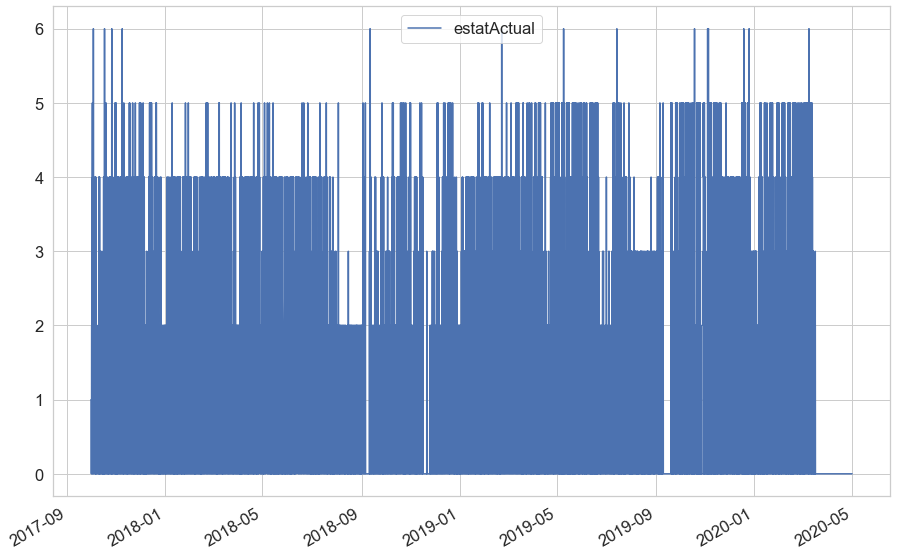

In [15]:
seaborn.set(font_scale=1.5, style="whitegrid")

data=data_trafico.loc[(data_trafico["idTram"] == 1), ['data', 'estatActual']].set_index('data')
ax = data.plot(figsize=(15,10))
ax.set_xlabel('')
plt.show()

En esta gráfica se puede intuir ya un patrón en el comportamiento del tránsito en este tramo. Observamos como, en los meses de verano, se aprecia un gran periodo en el cual el tránsito es registrado como flúido en todo momento. Para los demás meses, se adivina alzas y bajas periódicas.

En la siguiente gráfica nos centramos en un periodo de tiempo más corto de únicamente dos semanas.

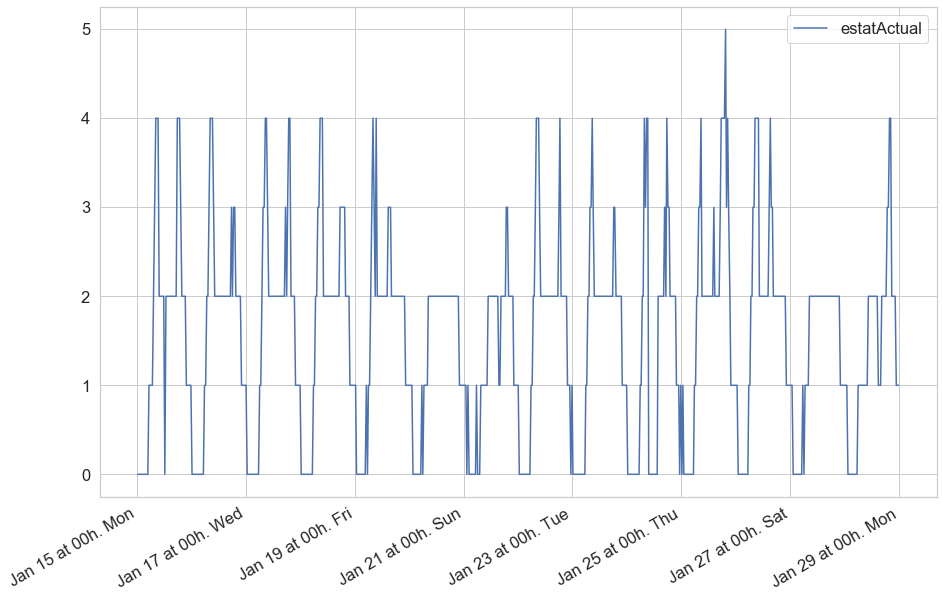

In [16]:
seaborn.set(font_scale=1.5, style="whitegrid")

data=data_trafico.loc[(data_trafico["idTram"] == 1), ['data', 'estatActual']].set_index('data')['2018-01-15':'2018-01-28']
ax = data.plot(figsize=(15,10))

date_form = DateFormatter("%b %d at %Hh. %a")
ax.xaxis.set_major_formatter(date_form)

#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO, TU, WE, TH, FR, SA, SU), interval=1))
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.set_xlabel('')
plt.show()

Ahora observamos claramente que se repite un mismo patrón semanalmente. Vemos como hay picos de tráfico a primeras y últimas horas del día, de lunes a viernes (seguramente coincidiendo con la entrada y salida del trabajo). Los fines de semana se observa una relajación del tráfico.

# 3. Selección de tramos

Del análisis realizado para los datos de contaminación del aire, extraemos una selección de tramos de la vía, que utilizaremos para obtener la serie temporal de tránsito de vehículos en cada una de las estaciones de vigilancia. Así, tenemos la siguiente selección de tramos por estación (entre paréntesis tenemos el CODI_EOI para cada estación):

- Observatori Fabra (8019058): 64, 65, 511 y 512
- Parc Vall Hebron (8019054): 438 y 439
- Poblenou (8019004): 421 y 481
- Ciutadella (8019050): 289, 290, 489 y 490
- Eixample (8019043): 118, 138 y 142
- Gracia - Sant Gervasi (8019044): 77, 78, 79, 80 y 467
- Sants (8019042): 50, 51, 129, 448 y 449
- Palau Reial (8019057): 3, 4, 16 y 17

A continuación construiremos un dataframe con los valores de tránsito para cada estación de vigilancia anterior. Para eso, extraeremos las series temporales para cada uno de los tramos seleccionados para cada estación y, nos quedaremos con el valor máximo de tránsito en todos ellos en cada instante registrado.

Inicialmente construimos un diccionario con la asignación entre estaciones de vigilancia y tramos expuesta arriba:

In [17]:
trams_eois = [{'codi_eoi':8019058, 'trams':[64, 65, 511, 512]},
              {'codi_eoi':8019054, 'trams':[438, 439]}, 
              {'codi_eoi':8019004, 'trams':[421, 481]},
              {'codi_eoi':8019050, 'trams':[289, 290, 489, 490]}, 
              {'codi_eoi':8019043, 'trams':[118, 138, 142]},
              {'codi_eoi':8019044, 'trams':[77, 78, 79, 80, 467]}, 
              {'codi_eoi':8019042, 'trams':[50, 51, 129, 448, 449]},                 
              {'codi_eoi':8019057, 'trams':[3, 4, 16, 17]}]

Ahora calculamos los datos que nos interesan y lo guardamos en un dataframe:

In [18]:
data_trafico_red = pd.DataFrame()
for trams_eoi in trams_eois:
    codi_eoi=trams_eoi['codi_eoi']
    trams=trams_eoi['trams']
    if len(trams) > 0:
        data=data_trafico.loc[(data_trafico["idTram"] == trams[0]), ['data', 'estatActual']].set_index('data')
        s0 = pd.Series(data['estatActual'].values, index=data.index)
        s0.head()
        for i in range(1,len(trams)):
            data=data_trafico.loc[(data_trafico["idTram"] == trams[i]), ['data', 'estatActual']].set_index('data')
            si = pd.Series(data['estatActual'].values, index=data.index)
            s0 = s0.combine(si, max)
            
        print ('CODI_EOI: {}  From: {} To: {}'.format(codi_eoi, s0.first_valid_index(), s0.last_valid_index()))
        df = s0.to_frame().reset_index()
        df['codi_eoi'] = codi_eoi
        data_trafico_red = data_trafico_red.append(df, ignore_index=False, sort=False)
data_trafico_red.columns = ['data', 'estatActual', 'codi_eoi']
data_trafico_red.head()        

CODI_EOI: 8019058  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019054  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019004  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019050  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019043  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019044  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019042  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50
CODI_EOI: 8019057  From: 2017-10-01 00:20:55 To: 2020-04-30 23:55:50


,data,estatActual,codi_eoi
0,2017-10-01 00:20:55,2,8019058
1,2017-10-01 00:50:56,1,8019058
2,2017-10-01 01:20:53,1,8019058
3,2017-10-01 01:50:56,1,8019058
4,2017-10-01 02:20:53,1,8019058


In [19]:
# Read air stations metadata file
filename = "../data/data_air_stations.csv"
data_air_stations = pd.read_csv(filename, sep=',', encoding = "UTF-8")
data_air_stations.head()

,CODI_EOI,NOM_ESTACIO,TIPUS_ESTACIO,AREA URBANA,LATITUD,LONGITUD,ALTITUD,CONTAMINANT
0,8019003,Barcelona (St. Gervasi),traffic,urban,41.401128,2.146942,75.0,['H2S' 'NOX']
1,8019004,Barcelona (Poblenou),background,urban,41.403878,2.204501,3.0,['CO' 'NO' 'NO2' 'NOX' 'O3' 'PM10' 'SO2']
2,8019039,Barcelona (Sagrera),traffic,urban,41.422213,2.190555,12.0,['NOX']
3,8019042,Barcelona (Sants),traffic,urban,41.378783,2.133099,35.0,['CO' 'NO' 'NO2' 'NOX' 'SO2']
4,8019043,Barcelona (Eixample),traffic,urban,41.385314,2.153800,26.0,['CO' 'NO' 'NO2' 'NOX' 'O3' 'PM10' 'SO2']


Veamos el aspecto que tienen los datos obtenidos para cada estación.

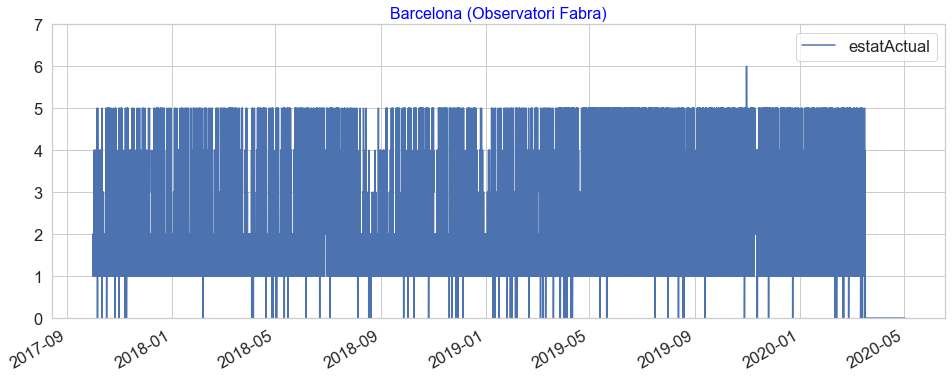

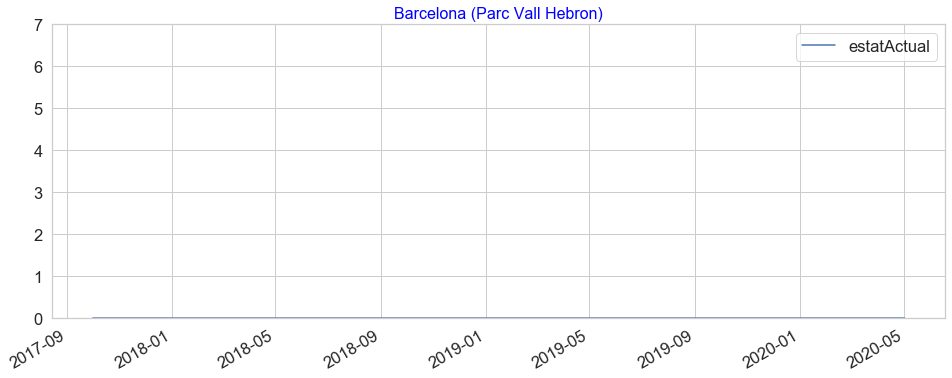

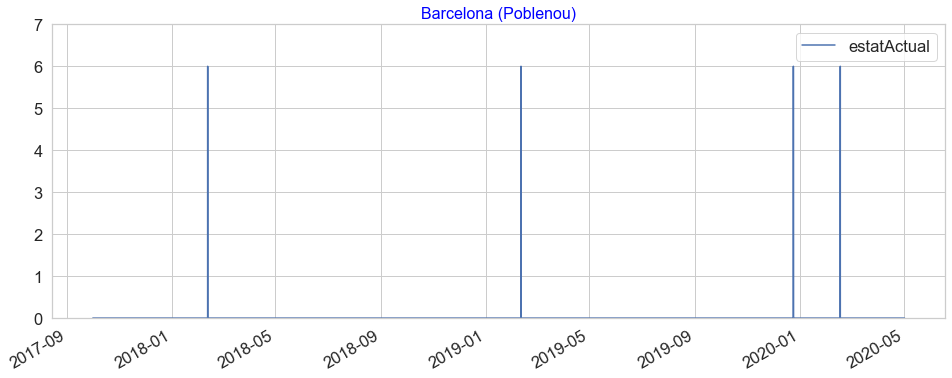

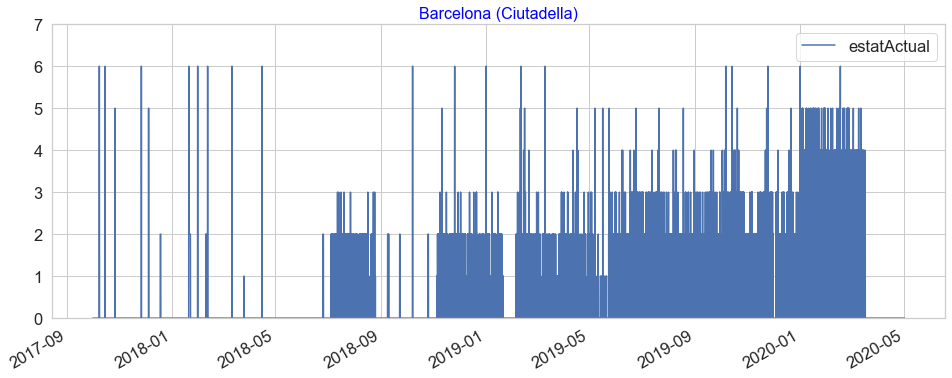

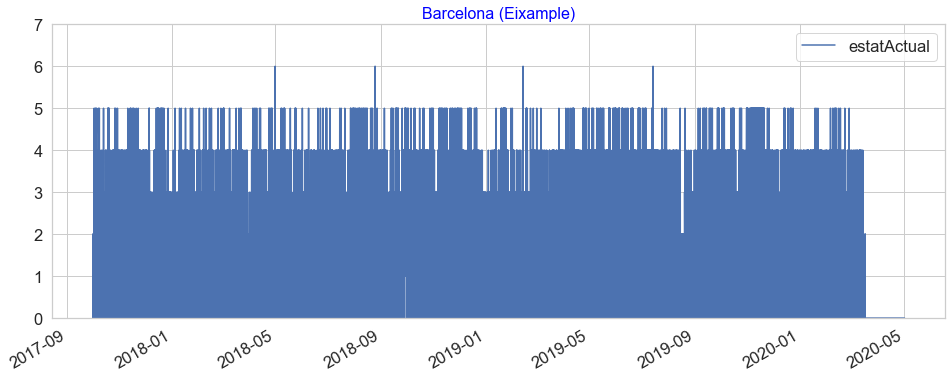

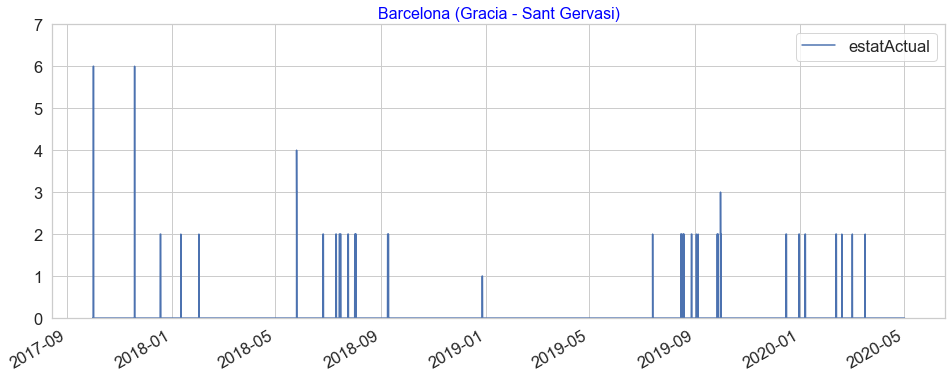

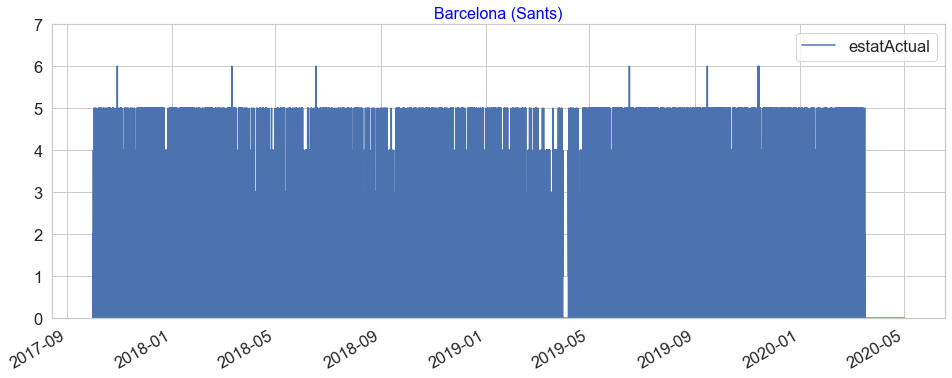

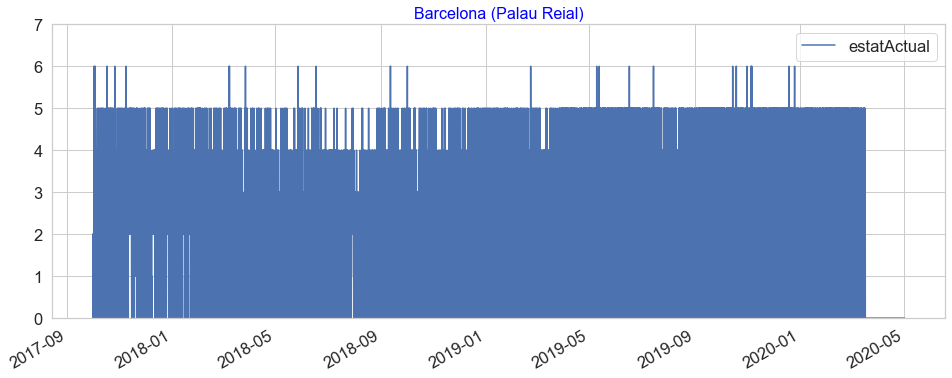

In [20]:
idStations = data_trafico_red['codi_eoi'].unique()
for idStation in idStations :
    nom_estacio=data_air_stations.loc[data_air_stations["CODI_EOI"] == idStation,'NOM_ESTACIO'].iloc[0]
    title='{}'.format(nom_estacio)
    data=data_trafico_red.loc[(data_trafico_red["codi_eoi"] == idStation), ['data', 'estatActual']].set_index('data')    
    if data.count()[0] > 0:  
        ax = data.plot(figsize=(16,6))     
        ax.set_ylim(0,7)
        ax.set_title(title, fontsize=16, color='blue')
        ax.set_xlabel('')

Guardamos el dataframe obtenido

In [21]:
data_trafico_red.to_csv(r'../data/data_trafico_red.csv', index = False)

# Bibliografía

- Numpy developer manual. https://numpy.org/devdocs/

- Pandas documentation. https://pandas.pydata.org/docs/

- Folium. https://python-visualization.github.io/folium/